## Importing neccessary libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

## Loading Data

In [ ]:
#Construct an ImageDataGenerator object:
DIRECTORY = "/content/drive/MyDrive/Colab/Covid19-classifier-X-rays/Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

In [ ]:
training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1,

#Randomly rotate the image between -25,25 degrees
rotation_range=25,

#Shift the image along its width by up to +/- 5%
width_shift_range=0.05,

#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,

)

training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='training')


Found 251 images belonging to 3 classes.


In [ ]:
validation_data_generator = ImageDataGenerator()

validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')


Found 251 images belonging to 3 classes.


## Modeling

In [ ]:
def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu"))
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu"))
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu"))
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    # summarize model
    model.summary()
    return model

In [ ]:
model = design_model(training_iterator)


Compiling model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 5)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 42, 42, 5)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 5)         630       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 5)          0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None

### Training

In [ ]:
# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)


# fit the model with early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=40,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es])

Epoch 1/40
7/7 [==============================] - 6s 661ms/step - loss: 1.0923 - categorical_accuracy: 0.4104 - auc_1: 0.5649 - val_loss: 22.6458 - val_categorical_accuracy: 0.4382 - val_auc_1: 0.5632
Epoch 2/40
7/7 [==============================] - 5s 599ms/step - loss: 1.0936 - categorical_accuracy: 0.4104 - auc_1: 0.5603 - val_loss: 15.4683 - val_categorical_accuracy: 0.4382 - val_auc_1: 0.5472
Epoch 3/40
7/7 [==============================] - 5s 605ms/step - loss: 1.0826 - categorical_accuracy: 0.4303 - auc_1: 0.5843 - val_loss: 13.2622 - val_categorical_accuracy: 0.4382 - val_auc_1: 0.5521
Epoch 4/40
7/7 [==============================] - 4s 588ms/step - loss: 1.0737 - categorical_accuracy: 0.4223 - auc_1: 0.6038 - val_loss: 9.5549 - val_categorical_accuracy: 0.4183 - val_auc_1: 0.5520
Epoch 5/40
7/7 [==============================] - 5s 614ms/step - loss: 1.0711 - categorical_accuracy: 0.4582 - auc_1: 0.6087 - val_loss: 16.4431 - val_categorical_accuracy: 0.4382 - val_auc_1: 0.5

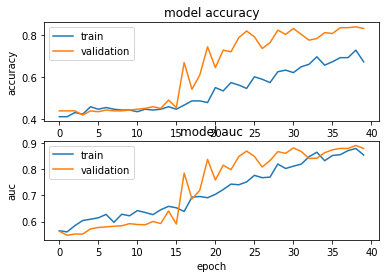

In [ ]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

## Results evaluation


In [ ]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

              precision    recall  f1-score   support

       Covid       0.51      0.44      0.47       111
      Normal       0.31      0.33      0.32        70
   Pneumonia       0.30      0.34      0.32        70

    accuracy                           0.38       251
   macro avg       0.37      0.37      0.37       251
weighted avg       0.40      0.38      0.39       251

[[49 29 33]
 [23 23 24]
 [24 22 24]]


In [ ]:
import itertools
import numpy as np
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):


   Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

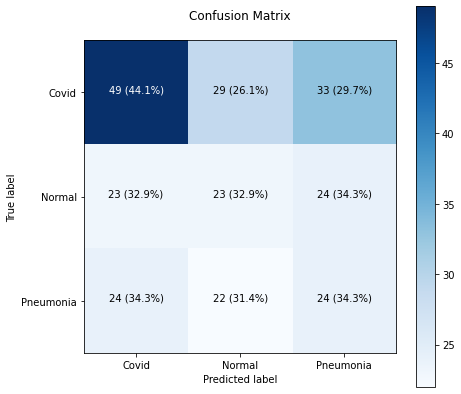

In [ ]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=true_classes,
                      y_pred=predicted_classes,
                      classes=class_labels,
                      figsize=(7, 7),
                      text_size=10)
